In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

import itertools
from kernels import HMC_our, HMC_vanilla, Reverse_kernel_sampling
from target import GMM_target, GMM_target2, Funnel, Gaussian_target, Banana
from args import get_args

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

import pdb

In [2]:
args = get_args()

In [3]:
target = Banana(args)

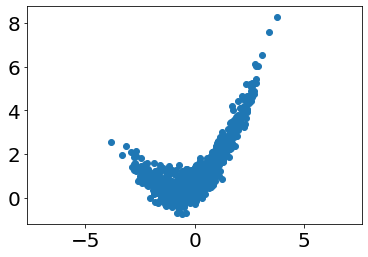

In [4]:
target_samples = target.get_samples(n=1000).cpu().numpy()
plt.scatter(target_samples[:, 0], target_samples[:, 1])
plt.axis('equal');

#### Common setup

In [5]:
## Here we fix K
args.n_steps = args.K # how many samples to use
args.n_warmup = 0 # num of first samples to refuse

args.n_chains = 10 # how many chains to model
args.data_dim = 2

limit = 7

In [6]:
vanilla_kernel = HMC_vanilla(args)

## Vanilla HMC

In [7]:
q_new = args.std_normal.sample((args.n_chains, args.z_dim))
p_new = args.std_normal.sample((args.n_chains, args.z_dim))
        
print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_vanilla = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)

print("Now we are sampling!")
iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_vanilla[i] = q_new
iterator.close()

0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 155.40it/s]

Now we are running warmup!
Now we are sampling!


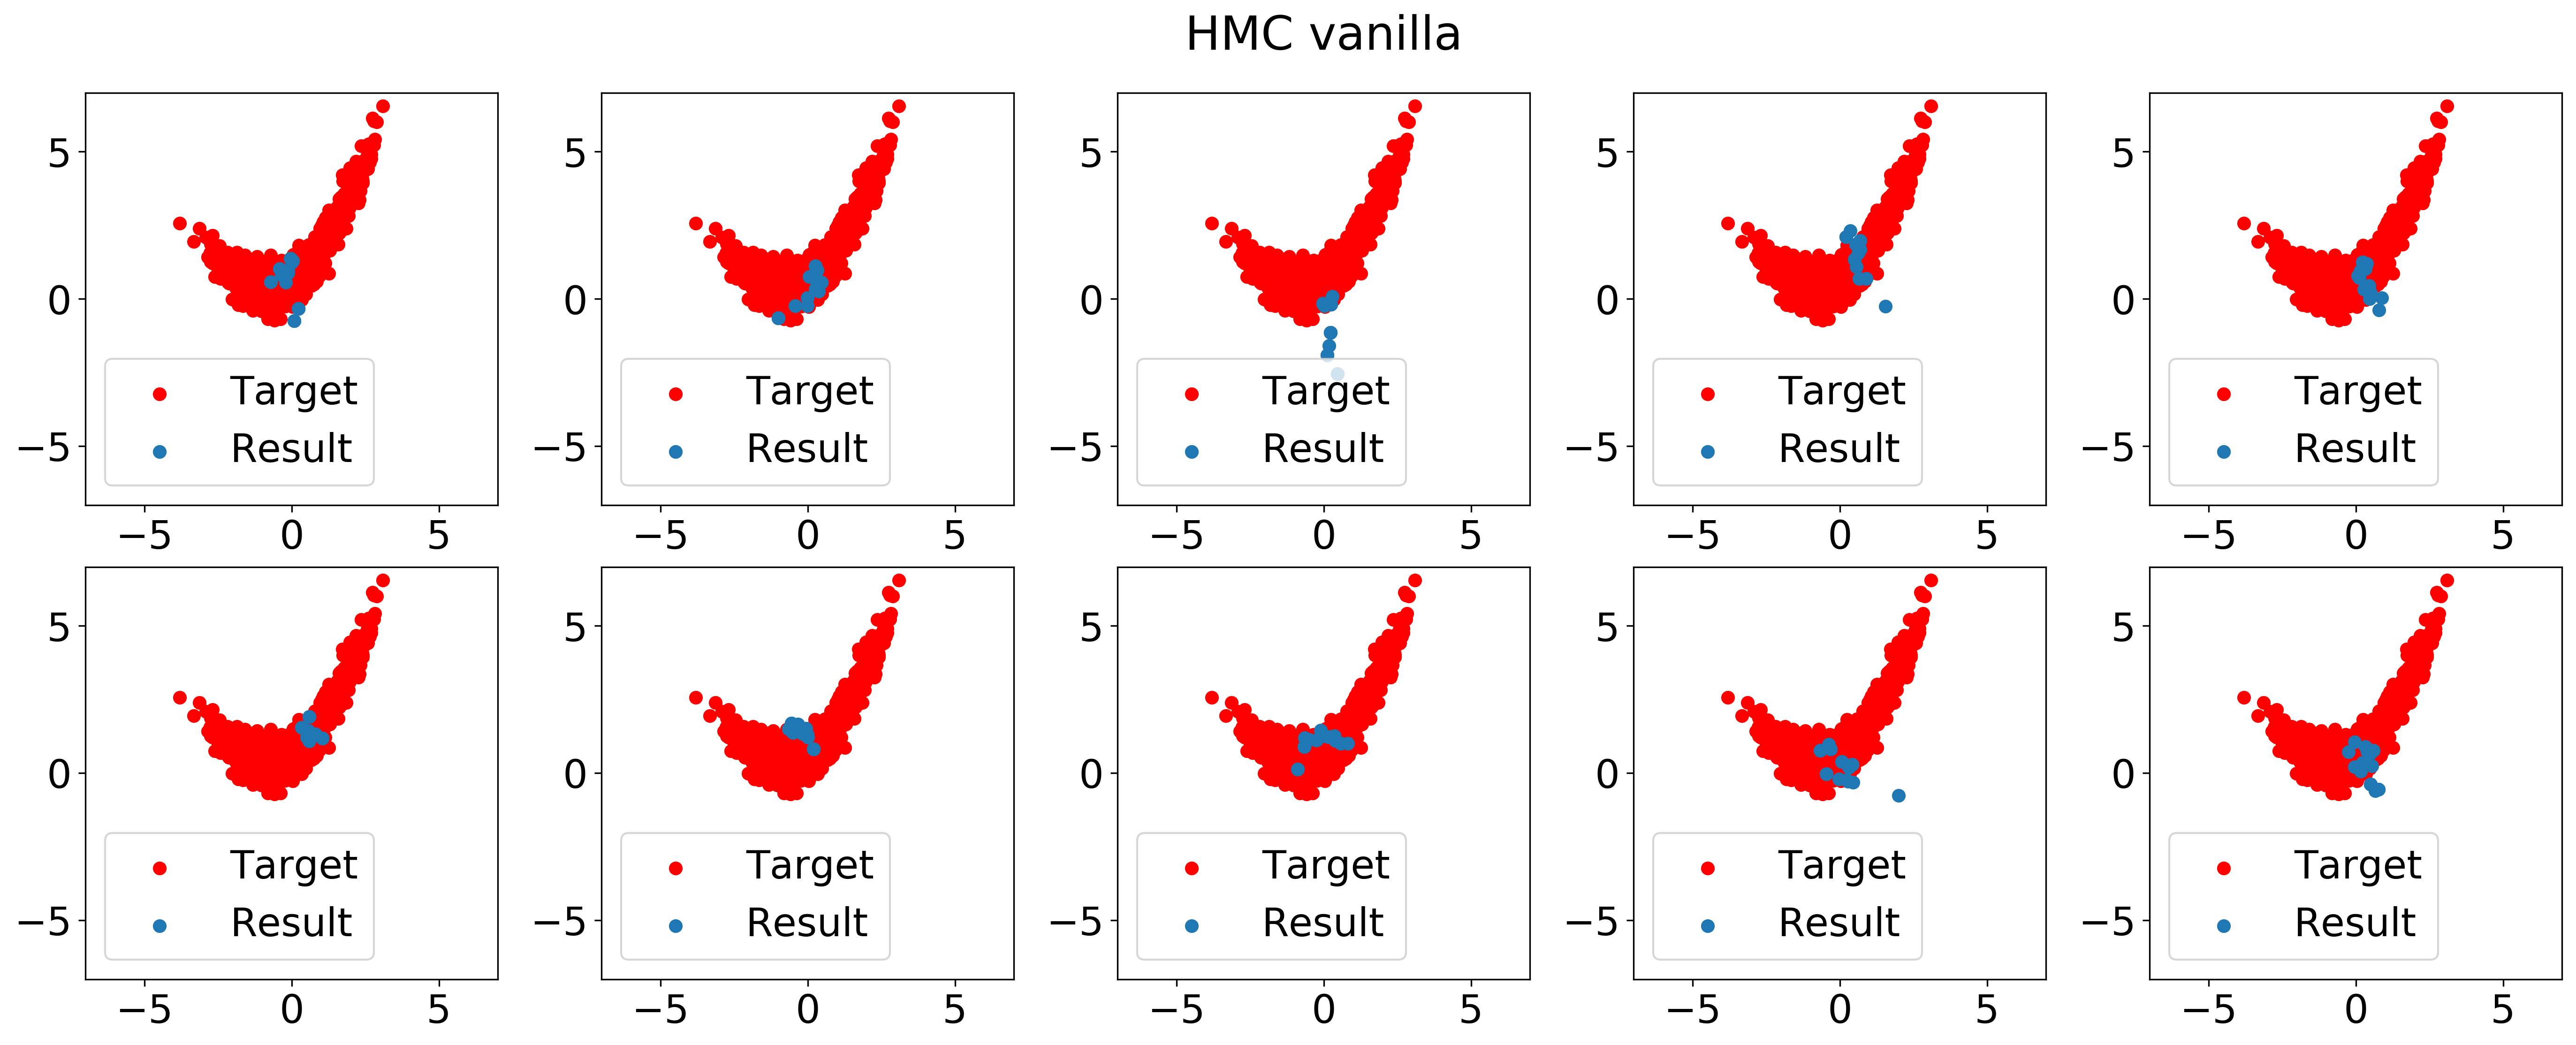

In [8]:
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC vanilla')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_vanilla[:, chain_num, 0].cpu(), samples_vanilla[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

## Hoffman HMC

In [9]:
##### Minimize KL first

mu_init_hoff = nn.Parameter(torch.zeros(args.data_dim, device=args.device, dtype=args.torchType))
sigma_init_hoff = nn.Parameter(torch.ones(args.data_dim, device=args.device, dtype=args.torchType))
optimizer = torch.optim.Adam(params=[mu_init_hoff, sigma_init_hoff])

init_distr = torch.distributions.Normal(loc=mu_init_hoff, scale=nn.functional.softplus(sigma_init_hoff))
for i in tqdm(range(20000)):
#     pdb.set_trace()
    q_init = init_distr.sample((500, ))
    current_kl = init_distr.log_prob(q_init).sum(1) - target.get_logdensity(z=q_init)
    torch.mean(current_kl).backward() ## minimize KL
    optimizer.step()
    optimizer.zero_grad()
    init_distr = torch.distributions.Normal(loc=mu_init_hoff, scale=nn.functional.softplus(sigma_init_hoff))
    if i % 2000 == 0:
        print(current_kl.mean().cpu().detach().numpy())

  1%|          | 154/20000 [00:00<00:26, 753.68it/s]

23.298111


 11%|█         | 2122/20000 [00:02<00:22, 779.23it/s]

21.50102


 20%|██        | 4093/20000 [00:05<00:20, 780.67it/s]

23.273577


 31%|███       | 6123/20000 [00:07<00:17, 777.65it/s]

22.414177


 41%|████      | 8154/20000 [00:10<00:15, 777.62it/s]

24.687641


 51%|█████     | 10108/20000 [00:12<00:12, 778.29it/s]

23.204365


 61%|██████    | 12120/20000 [00:15<00:09, 801.51it/s]

24.494474


 71%|███████   | 14117/20000 [00:18<00:07, 770.88it/s]

20.766119


 81%|████████  | 16145/20000 [00:20<00:04, 773.12it/s]

26.57863


 90%|█████████ | 18095/20000 [00:23<00:02, 773.74it/s]

22.856876


100%|██████████| 20000/20000 [00:25<00:00, 779.88it/s]


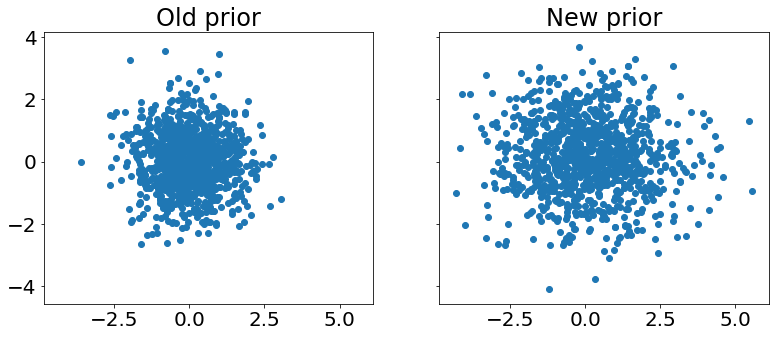

In [10]:
### Plot new prior
prior_old = args.std_normal.sample((1000, 2)).cpu().detach().numpy()

mu_init_hoff.requires_grad_(False)
sigma_init_hoff.requires_grad_(False)
prior_new = mu_init_hoff + args.std_normal.sample((1000, 2)) * nn.functional.softplus(sigma_init_hoff)
prior_new = prior_new.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, figsize=(13, 5), sharex=True, sharey=True)
ax[0].scatter(prior_old[:, 0], prior_old[:, 1])
ax[1].scatter(prior_new[:, 0], prior_new[:, 1])
ax[0].set_title('Old prior')
ax[1].set_title('New prior');

In [11]:
### Then run HMC (without warmup) of length K

q_new = mu_init_hoff + args.std_normal.sample((args.n_chains, args.z_dim)) * nn.functional.softplus(sigma_init_hoff)
p_new = args.std_normal.sample((args.n_chains, args.z_dim))
        
print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_hoffman = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)

print("Now we are sampling!")
iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_hoffman[i] = q_new
iterator.close()

0it [00:00, ?it/s]
100%|██████████| 20/20 [00:00<00:00, 177.95it/s]

Now we are running warmup!
Now we are sampling!


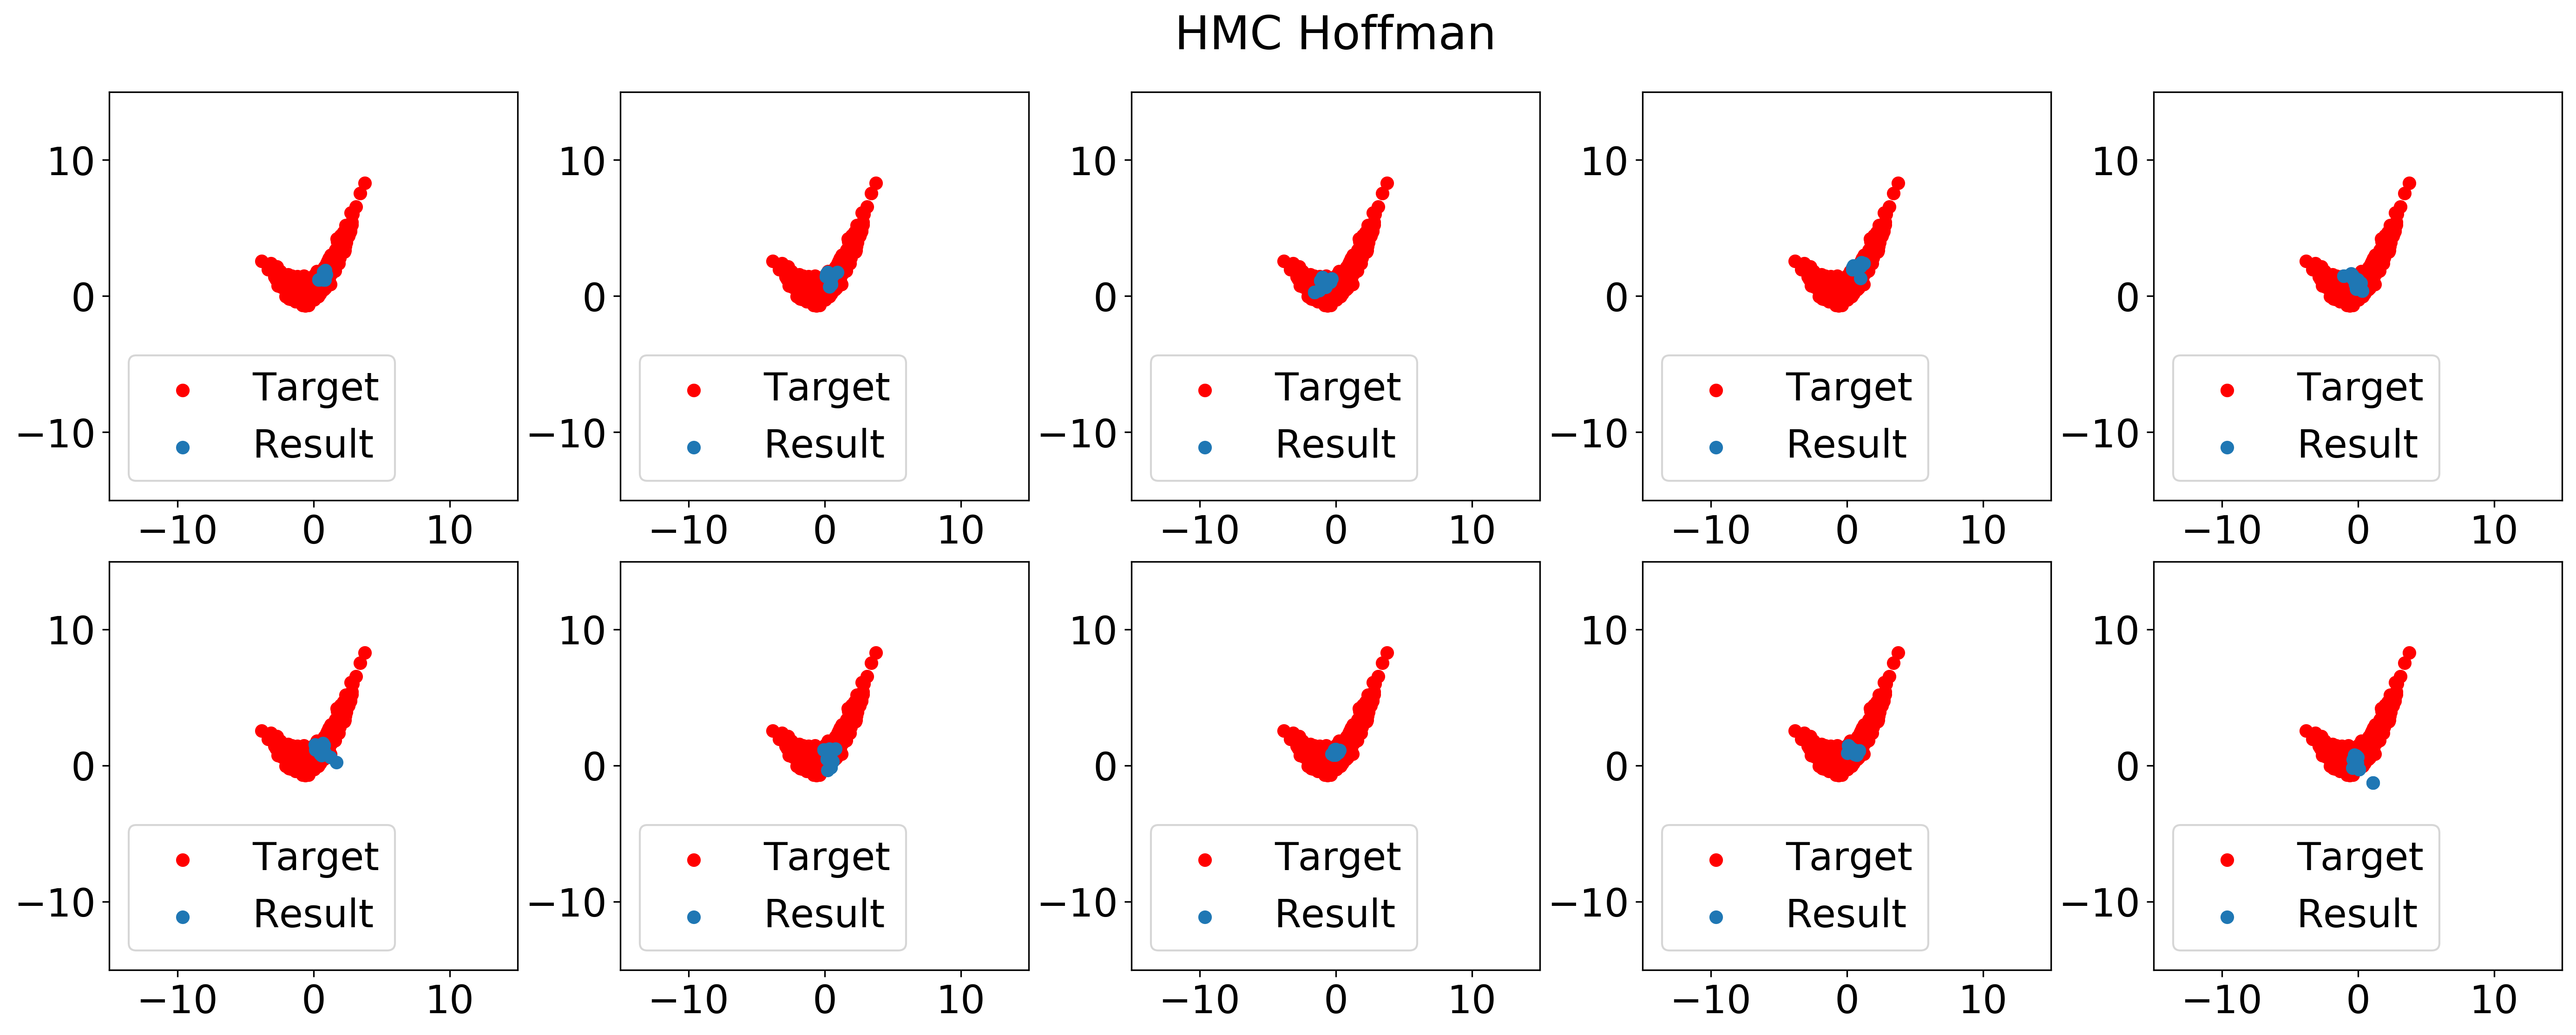

In [12]:
### Plot received chains

limit = 15
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC Hoffman')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_hoffman[:, chain_num, 0].cpu(), samples_hoffman[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

## Ours HMC

In [13]:
if args.learnable_reverse:
    reverse_kernel = Reverse_kernel_sampling(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
    our_kernel_best = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    our_kernel_best = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
        
for p in transitions.parameters():
    transitions.requires_grad_(False)
    
mu_init = nn.Parameter(torch.zeros(args.data_dim, device=args.device, dtype=args.torchType))
sigma_init = nn.Parameter(torch.ones(args.data_dim, device=args.device, dtype=args.torchType))

params = list(transitions.parameters()) + list(reverse_params) + [mu_init, sigma_init]

optimizer = torch.optim.Adam(params=params)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=200, factor=0.9)

##### Training

  0%|          | 0/5000 [00:00<?, ?it/s]

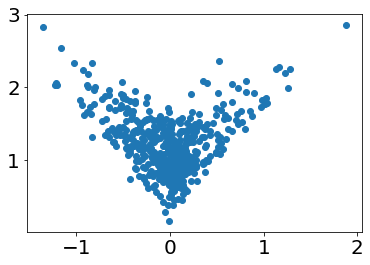

  0%|          | 2/5000 [00:00<15:56,  5.23it/s]

Current lr:  0.001
On batch number 0 ELBO is -21.432353973388672
On batch number 0 Best ELBO is -inf


 10%|█         | 500/5000 [01:11<10:40,  7.03it/s]

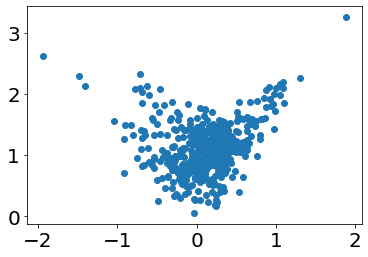

 10%|█         | 502/5000 [01:11<11:58,  6.26it/s]

Current lr:  0.0009000000000000001
On batch number 500 ELBO is -22.245960235595703
On batch number 500 Best ELBO is -20.58987045288086


 20%|██        | 1000/5000 [02:22<09:27,  7.05it/s]

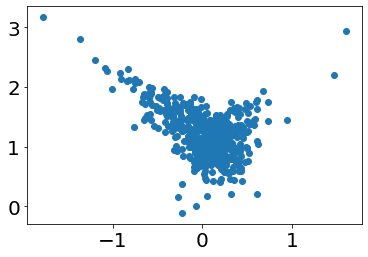

 20%|██        | 1002/5000 [02:22<10:22,  6.42it/s]

Current lr:  0.000729
On batch number 1000 ELBO is -21.12388801574707
On batch number 1000 Best ELBO is -20.575117111206055


 30%|███       | 1500/5000 [03:34<08:21,  6.98it/s]

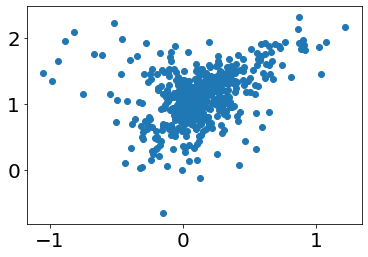

 30%|███       | 1502/5000 [03:34<09:22,  6.22it/s]

Current lr:  0.00059049
On batch number 1500 ELBO is -21.451934814453125
On batch number 1500 Best ELBO is -20.431686401367188


 32%|███▏      | 1607/5000 [03:49<08:04,  7.00it/s]

In [ ]:
print_info_ = 500
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

x_lim = limit
y_lim = limit

def compute_loss(q_new, p_new, u, p_old, sum_log_alpha, sum_log_jac, all_directions=None, sum_log_sigma=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=q_new, a=all_directions)
    else:
        log_r = -args.K * torch_log_2
    log_p = target.get_logdensity(z=q_new) + args.std_normal.log_prob(p_new).sum(1)
    log_m = -sum_log_sigma + args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac + sum_log_alpha
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full.detach().mean().item(), grad_elbo


iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for k in range(args.K)]
        
    # sample initial q and p
    u = args.std_normal.sample((args.train_batch_size, args.z_dim))
    q_old = mu_init + u * nn.functional.softplus(sigma_init)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))
    sum_log_sigma = torch.sum(nn.functional.softplus(sigma_init))
    
    # prepare tensors for auxilary stuff
    sum_log_alpha = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
    
    q = q_old
    p = p_old
    if (batch_num) % print_info_ == 0:
        array_z = []
        array_directions = []
        array_alpha = []
        array_prop = []
        
    if args.learnable_reverse:
        all_directions = torch.tensor([], device=args.device)
    else:
        all_directions = None
        
    # run training cycle
    for k in range(args.K):
        if args.amortize:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions.make_transition(q_old=q,
                                            p_old=p, k=cond_vectors[k], target_distr=target)
        else:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions[k].make_transition(q_old=q,
                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
#         if (batch_num) % print_info_ == 0:
#             print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
#                                                         (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
#             print('Step size for {}-th transition is {}'.format(k, transitions[k].gamma.detach().exp()))
#             print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))
        sum_log_alpha = sum_log_alpha + current_log_alphas
        sum_log_jacobian = sum_log_jacobian + log_jac
        if (batch_num) % print_info_ == 0:
            array_z.append(q.detach())
            array_directions.append(directions.detach())
            array_alpha.append(current_log_alphas.detach())
            array_prop.append(q_prop.detach())
        if args.learnable_reverse:
            all_directions = torch.cat([all_directions, directions.detach().view(-1, 1)], dim=1)
    elbo_full, grad_elbo = compute_loss(q_new=q, p_new=p, u=u, p_old=p_old, sum_log_jac=sum_log_jacobian,
                                            sum_log_alpha=sum_log_alpha, all_directions=all_directions, sum_log_sigma=sum_log_sigma)
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))
        
#         fig, ax = plt.subplots(ncols=args.K, figsize=(30, 10))
#         label = ['Same', 'Forward']
#         for kk in range(args.K):
#             ax[kk].scatter(array_prop[kk][:, 0].cpu().numpy(), array_prop[kk][:, 1].cpu().numpy(), color='r', label='Proposals')
#             for d in [0., 1.]:
#                 z_c = array_z[kk][array_directions[kk]==d]
#                 alpha_c = array_alpha[kk][array_directions[kk]==d].cpu().exp().numpy()
#                 color = np.zeros((z_c.shape[0], 4))
#                 color[:, 3] = alpha_c
#                 color[:, int(d + 1)] = 1.
#                 ax[kk].scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), color=color, label=label[int(d)])
# #                 ax[kk].set_xlim((-x_lim, x_lim))
# #                 ax[kk].set_ylim((-y_lim, y_lim))
#                 ax[kk].legend()
        plt.show();
    (-grad_elbo).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        iterator.close()
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        our_kernel_best.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break

In [ ]:
# our_kernel_best = transitions
for p in our_kernel_best.parameters():
    p.requires_grad_(False)
    
mu_init.requires_grad_(False)
sigma_init.requires_grad_(False)

In [ ]:
### Plot new prior
prior_old = args.std_normal.sample((1000, 2)).cpu().detach().numpy()

prior_new = mu_init + args.std_normal.sample((1000, 2)) * nn.functional.softplus(sigma_init)
prior_new = prior_new.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, figsize=(13, 5), sharex=True, sharey=True)
ax[0].scatter(prior_old[:, 0], prior_old[:, 1])
ax[1].scatter(prior_new[:, 0], prior_new[:, 1])
ax[0].set_title('Old prior')
ax[1].set_title('New prior');

In [ ]:
# q_new = q_init
# p_new = p_init

# print("Now we are running warmup!")
# iterator = tqdm(range(args.n_warmup // args.K))
# for i in iterator:
#     q_new = q_new.detach().requires_grad_(True)
#     p_new = p_new.detach().requires_grad_(True)
#     for k in range(args.K):
#         cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
#         q_new, p_new, _, _, _, _ = our_kernel_best[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
#                                                                    k=cond_vectors[k])
# iterator.close()
    
# samples_our = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)
# print("Now we are sampling!")

# iterator = tqdm(range(args.n_steps // args.K))
# for i in iterator:
#     q_new = q_new.detach().requires_grad_(True)
#     p_new = p_new.detach().requires_grad_(True)
#     for k in range(args.K):
#         cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
#         q_new, p_new, _, _, a, _ = our_kernel_best[k].make_transition(q_old=q_new, p_old=p_new, target_distr=target,
#                                                                        k=cond_vectors[k])
#         samples_our[i] = q_new.detach()
# iterator.close()

In [ ]:
# target_samples = target.get_samples(n=1000).cpu().numpy()

# fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
# plt.suptitle('HMC our')
# for chain_num in range(args.n_chains):
#     ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
#     ax[chain_num // 5, chain_num % 5].scatter(samples_our[:, chain_num, 0].cpu(), samples_our[:, chain_num, 1].cpu(), label='Result')
#     ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
#     ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
#     ax[chain_num // 5, chain_num % 5].set_aspect('equal')
#     ax[chain_num // 5, chain_num % 5].legend()
# plt.tight_layout();
# plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

In [ ]:
# n_samples = 10000
n_chains = 50
repetitions = 1

init_q = mu_init + args.std_normal.sample((n_chains, args.z_dim)).requires_grad_(True) * nn.functional.softplus(sigma_init)
q = init_q
our_samples = []
# our_samples.append(q.cpu().detach().numpy())

# init_p = args.std_normal.sample((n_samples, args.z_dim))
# p = init_p

for rep in range(repetitions):
    init_p = args.std_normal.sample((n_chains, args.z_dim))
    p = init_p
    cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
    for k in range(args.K):
        if args.amortize:
            q, p, _, _, _, _ = our_kernel_best.make_transition(q_old=q,
                                            p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        else:
            q, p, _, _, _, _ = our_kernel_best[k].make_transition(q_old=q,
                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        our_samples.append(q.cpu().detach().numpy())

In [ ]:
our_samples = np.array(our_samples)

In [ ]:
our_samples.shape

In [ ]:
target_samples.shape

In [ ]:
chain_ind = 11


plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(our_samples[:, chain_ind, 0], our_samples[:, chain_ind, 1], label='our HMC')
# plt.xlim((-4, 4))
# plt.ylim((-4, 4))
plt.axis('equal')
plt.legend();
